<a href="https://colab.research.google.com/github/yerriswamys2020/AIML_Lab/blob/main/DOA_UnitaryDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estimating DOA using ULA with unitary transformation and plotting:
1. True DOAs versus Predicted DOAs
2. MAE Plot

In [1]:
# Addiding Necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Unitary Transfroamtion
def unitary_tran(x, snapshot_number, sensor_number): # x is received signal, snapshot_number is signal_dim, and sensor_nmber is num_antennas
    # Construct Qm and Q2L
    J = np.fliplr(np.eye(sensor_number//2))

    Qm = (1 / np.sqrt(2)) * np.block([
        [np.eye(sensor_number//2), 1j * np.eye(sensor_number//2)],
        [J, -1j * J]
    ])

    JJ = np.fliplr(np.eye(snapshot_number))
    Q2L = (1 / np.sqrt(2)) * np.block([
        [np.eye(snapshot_number), 1j * np.eye(snapshot_number)],
        [JJ, -1j * JJ]
    ])

    # Construct Z matrix
    Jm = np.fliplr(np.eye(sensor_number))

    xx = np.conjugate(x.T).T
    Z = np.hstack([x, Jm @ xx @ JJ])
    Tx = Qm.conj().T @ Z @ Q2L

    # Transform Tx to obtain real-valued domain Rtmand return
    Rt = Tx @ Tx.conj().T / (2 * snapshot_number)
    return Rt

In [3]:
#Generate Uniform Antenna Array signal model
def generate_data(num_samples, num_antennas, num_sources, signal_dim, snr_db): #Signal dimension the number of sanpshots
    # Simulate received signals with known DOAs
    received_signals = []
    true_doas = []
    correlation_matrices = [] # List to store correlation matrices

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10)

    for i in range(num_samples): # Changed to i earlier it was _
        true_doa = np.sort(np.random.uniform(0, (np.pi/3), num_sources))
        received_signal = np.zeros((num_antennas, signal_dim), dtype=complex)

        # Generate source signals and array responses
        source_signals = []
        array_responses = []
        for source_idx, source_doa in enumerate(true_doa):
            array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * np.sin(source_doa))
            source_signal = np.random.randn(signal_dim) + 1j * np.random.randn(signal_dim)
            received_signal += array_response[:, np.newaxis] @ source_signal[np.newaxis, :]
            source_signals.append(source_signal)
            array_responses.append(array_response)

        # Calculate signal power
        # Sum of squared magnitudes of the received signal over all antennas and snapshots
        signal_power = np.mean(np.abs(received_signal)**2)

        # Calculate noise power based on desired SNR
        noise_power = signal_power / snr_linear

        # Generate complex Gaussian noise with the calculated noise power
        # The standard deviation of the real and imaginary parts should be sqrt(noise_power / 2)
        noise = (np.random.randn(num_antennas, signal_dim) + 1j * np.random.randn(num_antennas, signal_dim)) * np.sqrt(noise_power / 2)

        # Add noise to the received signal
        received_signal_noisy = received_signal + noise

        # Real correlation matrix uing unitart transformation
        Real_corr_matrix = unitary_tran(received_signal_noisy, signal_dim, num_antennas)

        #Constructing Data matrix
        true_doas.append(true_doa)
        correlation_matrices.append(Real_corr_matrix) # Append the correlation matrix
    correlation_matrices = np.array(correlation_matrices)
    return np.array(correlation_matrices), np.array(true_doas) # Returns Correlation Matrices array and True Angles array

In [4]:
#Set up the environment for antenna array

num_samples = 1000;
num_antennas = 8;
num_sources = 2;
snapshots = 3000;
snr_db = 10  # Desired SNR in dBubuntu version command

correlation_matrices, true_doas = generate_data(num_samples, num_antennas, num_sources, snapshots, snr_db)

In [5]:
#Split the data as training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(correlation_matrices, true_doas, test_size=0.3, random_state=42)

# Use only the real parts of the received signals removing imaginary part e
X_train = np.real(X_train)
X_test = np.real(X_test)

# Flatten the input data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize input data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [6]:
# Define the architecture of the Deep Neural Network,
# including layers, neurons, and activation functions,
# suitable for the DOA prediction task.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Initialize the Sequential model
model = Sequential()

# Add the Input layer as recommended by Keras
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Add the first Dense layer (no need for input_shape/input_dim here)
model.add(Dense(64, activation='relu'))

# Add hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Add the output layer
model.add(Dense(y_train.shape[1])) # Linear activation by default for regression

print("DNN model architecture defined successfully.")

DNN model architecture defined successfully.


In [7]:
#  compile the DNN model. The problem description specifies using the Adam
# optimizer and Mean Absolute Error (MAE) as the loss function.

from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='mae')

print("DNN model compiled successfully with Adam optimizer and MAE loss.")

DNN model compiled successfully with Adam optimizer and MAE loss.


In [8]:
# Next step is to train it using the fit method with the training data
# X_train_scaled and y_train.

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2 # Added validation split here
)

print("DNN model training completed.")

DNN model training completed.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


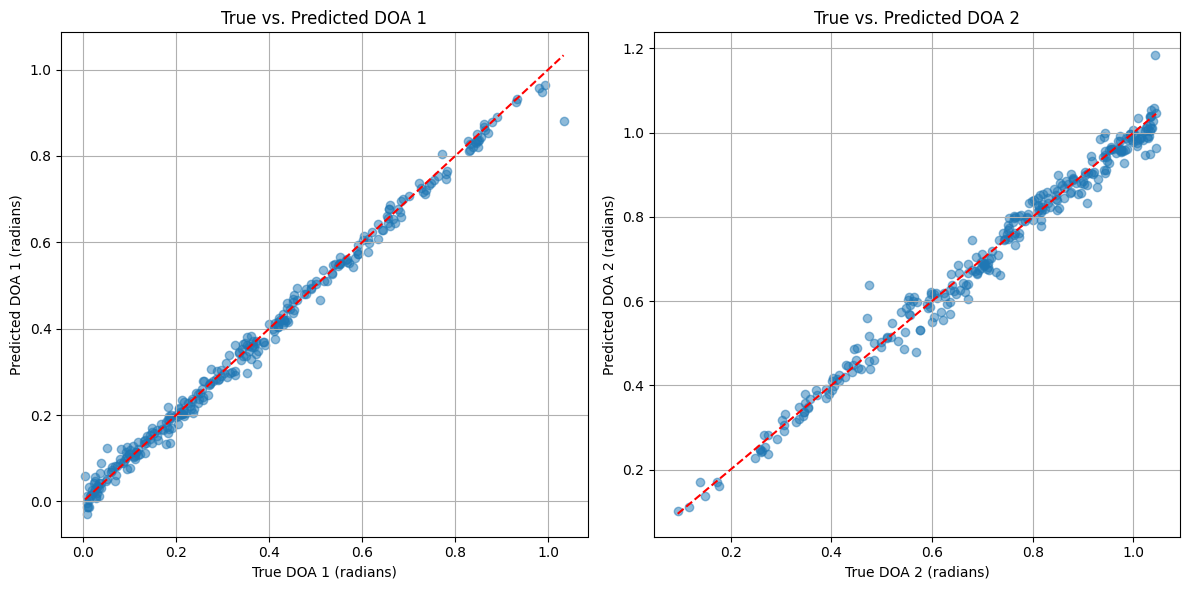

In [9]:
# Plot the results

import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Assuming y_test and y_pred contain two DOA values for each sample
# Let's plot each DOA separately

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # First subplot for DOA 1
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], 'r--') # Ideal prediction line
plt.xlabel("True DOA 1 (radians)")
plt.ylabel("Predicted DOA 1 (radians)")
plt.title("True vs. Predicted DOA 1")
plt.grid(True)

plt.subplot(1, 2, 2) # Second subplot for DOA 2
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], 'r--') # Ideal prediction line
plt.xlabel("True DOA 2 (radians)")
plt.ylabel("Predicted DOA 2 (radians)")
plt.title("True vs. Predicted DOA 2")
plt.grid(True)

plt.tight_layout()
plt.show()

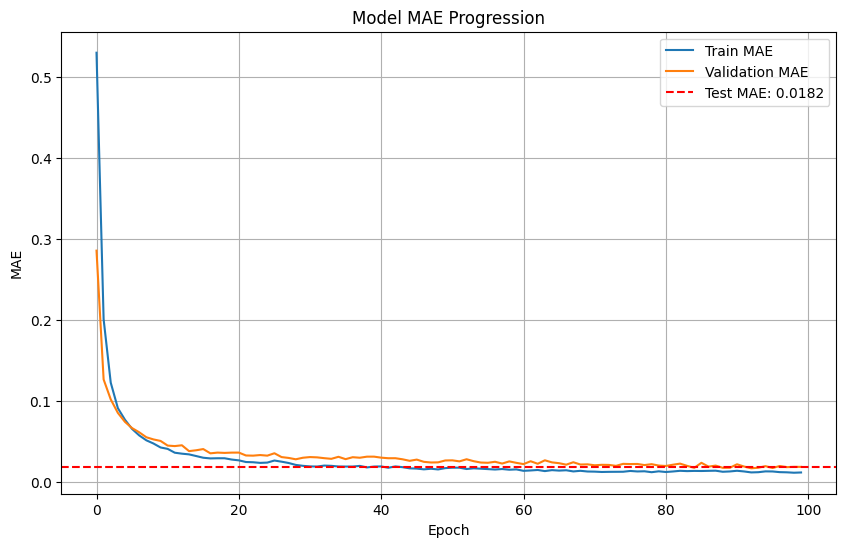

Test MAE: 0.0182


In [10]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train MAE')
plt.plot(history.history['val_loss'], label='Validation MAE')

# Evaluate the model on the test set to get test MAE
test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test MAE: {test_loss:.4f}')

plt.title('Model MAE Progression')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print(f"Test MAE: {test_loss:.4f}")